In [14]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")  
print(f"Using device: {device}")

Using device: cuda:2


In [15]:
import pickle

with open('all_abbasid_poems.pkl', 'rb') as file:
    data = pickle.load(file)

In [16]:
import numpy as np
import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm  # This auto-detects the environment (Jupyter/Terminal)


# Convert numpy array to DataFrame with column name "text"
df_data = pd.DataFrame(data, columns=["text"])
dataset = Dataset.from_pandas(df_data)

# Split into 80% train / 20% validation
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

In [17]:
# -*- coding: utf-8 -*-

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "UBC-NLP/AraT5v2-base-1024"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)


In [18]:
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding

# Tokenize the text data (batch tokenization)
def tokenize_function(examples):
    outputs = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)
    outputs["labels"] = outputs["input_ids"].copy()
    return outputs

tokenizer.pad_token = tokenizer.eos_token

# Apply the tokenizer to the training and validation datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/21211 [00:00<?, ? examples/s]

Map:   0%|          | 0/5303 [00:00<?, ? examples/s]

In [19]:
from transformers import DataCollatorWithPadding, EvalPrediction, TrainingArguments, Trainer

steps_per_epoch = len(tokenized_train)

training_args = TrainingArguments(
    output_dir="./arat5-finetuned",  
    overwrite_output_dir=True,
    num_train_epochs=5, 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,   
    eval_accumulation_steps=1,
    save_strategy="epoch",  
    logging_steps=steps_per_epoch,
    eval_strategy="epoch", 
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", 
    #report_to="none",                  
    disable_tqdm=False 
)

In [20]:
from transformers import TrainerCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.002287
2,No log,0.000963
3,No log,0.000730
4,No log,0.000597
5,No log,0.000554


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=6630, training_loss=0.06576517832944476, metrics={'train_runtime': 8883.6687, 'train_samples_per_second': 11.938, 'train_steps_per_second': 0.746, 'total_flos': 9.215873893269504e+16, 'train_loss': 0.06576517832944476, 'epoch': 5.0})

In [22]:
model.save_pretrained("./arat5_finetuned")
tokenizer.save_pretrained("./arat5_finetuned")

('./arat5_finetuned/tokenizer_config.json',
 './arat5_finetuned/special_tokens_map.json',
 './arat5_finetuned/spiece.model',
 './arat5_finetuned/added_tokens.json',
 './arat5_finetuned/tokenizer.json')

In [21]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the saved model and tokenizer
model_path = "./arat5_finetuned"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to the appropriate device (GPU if available)
device = "cpu"
model = model.to(device)

In [4]:
import torch
model.eval()  # Set model to evaluation mode

def generate_poem(prompt, max_length=100):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_length=max_length,
            num_beams=5,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    poem = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return poem

# Generate a poem with a given prompt
prompt = "يا حبيبي،"
print(generate_poem(prompt))


ويا حبيبي، يا حبيبي اليوم


In [11]:
prompt = ["و","لا", "يحب", "ترى", "نجوم", "في سماء", "في", "سماء"]
inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(model.device)

for p in prompt:
    inputs = tokenizer(p, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(model.device)
    generated_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=512,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(generated_text)
    print("\n")

/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


يا ترى في المنام وفي


لا تحزن إذا فقدت عزيزا. في


يا ترى في يوم القيامة من يوم الحساب وفي يوم الحشر وفي


يا ترى في


يا ترى في يوم القيامة من يوم الحشر ويوم القيامة ويوم الحساب ويوم الحشر


يا من في سماء من سماء في السماء من


يا ترى في المنام؟ في الحقيقة؟ ففي


يا سماء في سماء




In [17]:
prompt = "و لا يحب ترى نجوم في سماء "

# Tokenizing the entire prompt
inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(model.device)

# Generating text with higher creativity
generated_ids = model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=10, 
    num_return_sequences=1,
    no_repeat_ngram_size=3,
    temperature=0.7,        # Higher creativity
    top_p=0.95,             # More diverse word selection
    top_k=50,                # No restriction on top-k (disable)
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

# Decoding and printing the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)


و لا يحب ترى نجوم في سماء 


In [19]:
prompt = " نجوم"

# Tokenizing the entire prompt
inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(model.device)

# Generating text with higher creativity
generated_ids = model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=10, 
    num_return_sequences=1,
    no_repeat_ngram_size=3,
    temperature=0.7,        # Higher creativity
    top_p=0.95,             # More diverse word selection
    top_k=50,                # No restriction on top-k (disable)
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

# Decoding and printing the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)


يا ترى في يوم القيامة من يوم القيامة ومن يوم


In [26]:
import math

eval_loss = 0.000554
perplexity = math.exp(eval_loss)

print(f"Perplexity: {perplexity}")

Perplexity: 1.0005541534863425


In [24]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
import random 

vocab_size = tokenizer.vocab_size 

def generate_random_prompt(length=1):
    special_token_ids = set(tokenizer.all_special_ids)
    
    tokens = []
    while len(tokens) < length:
        token_id = random.randint(0, vocab_size - 1)
        if token_id not in special_token_ids:
            tokens.append(token_id)
    prompt_text = tokenizer.decode(tokens, clean_up_tokenization_spaces=True)
    return prompt_text

# Generate 50 random prompts of length 1 tokens
random_prompts = [generate_random_prompt(1) for _ in range(50)]

def compute_self_bleu(sentences, n_gram=4):
    scores = []
    for i, hypothesis in enumerate(sentences):
        # Use all other sentences as references
        references = [nltk.word_tokenize(s) for j,s in enumerate(sentences) if j != i]
        hypothesis_tokens = nltk.word_tokenize(hypothesis)
        # Compute BLEU score for hypothesis against all other references
        score = sentence_bleu(references, hypothesis_tokens, weights=tuple([1/n_gram]*n_gram))
        scores.append(score)
    return sum(scores) / len(scores)


In [25]:
total_self_bleu = 0

for p in random_prompts:    
    inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    generated_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=512,
        num_return_sequences=5,  # generate 5 sequences per prompt
        do_sample=True, 
        no_repeat_ngram_size=2,
        temperature=0.7,
        top_p=0.7,
        top_k=20,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
    self_bleu_score = compute_self_bleu(generated_texts)
    total_self_bleu += self_bleu_score
    
avg_self_bleu_score = self_bleu_score/len(random_prompts)
print(f"Avg Self-BLEU score (4-gram): {avg_self_bleu_score:.4f}")

/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

Avg Self-BLEU score (4-gram): 0.0019


In [7]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def calculate_self_bleu(generated_texts):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []

    for i, text in enumerate(generated_texts):
        # Use all other texts as reference
        references = [nltk.word_tokenize(t) for j, t in enumerate(generated_texts) if j != i]
        hypothesis = nltk.word_tokenize(text)
        
        # Calculate BLEU score for this text with smoothing
        score = sentence_bleu(references, hypothesis, smoothing_function=smoothing_function)
        bleu_scores.append(score)
    
        # Calculate the average BLEU score
    average_bleu = np.mean(bleu_scores)
    
    return bleu_scores, average_bleu

# Example usage with your generated poems
generated_poems = [
"يا ترى في المنام وفي",

"لا تحزن إذا فقدت عزيزا. في",

"يا ترى في يوم القيامة من يوم الحساب وفي يوم الحشر وفي",

"يا ترى في",

"يا ترى في يوم القيامة من يوم الحشر ويوم القيامة ويوم الحساب ويوم الحشر",

"يا من في سماء من سماء في السماء من",

"يا ترى في المنام؟ في الحقيقة؟ ففي",

"يا سماء في سماء",
    
"يا ترى في يوم القيامة من يوم القيامة ومن يوم"
]

self_bleu_scores, average_bleu = calculate_self_bleu(generated_poems)
print("Self-BLEU Scores:", self_bleu_scores)
print(f"Average Self-BLEU Score: {average_bleu:.4f}")

Self-BLEU Scores: [0.28574404296988, 0.033031643180138064, 0.6000342906130847, 0.40293516672844226, 0.4913270548144421, 0.07102233105535993, 0.17567205239427922, 0.24028114141347542, 0.6803749333171202]
Average Self-BLEU Score: 0.3312


[nltk_data] Downloading package punkt to /home/gdlteam3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


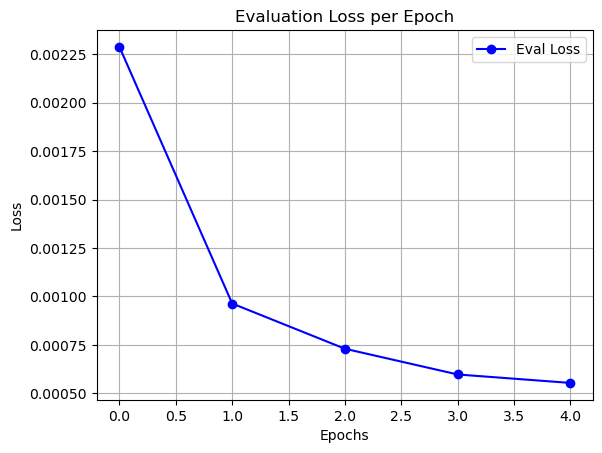

In [6]:
# plot eval loss for ft aragpt2 when replacing \n with .

import matplotlib.pyplot as plt
import json

# Load the JSON file
with open("./arat5-finetuned/checkpoint-6630/trainer_state.json", "r", encoding="utf-8") as f:
    train_state = json.load(f)

# Extract all eval_loss values from log_history
eval_losses = [
    entry["eval_loss"]
    for entry in train_state.get("log_history", [])
    if "eval_loss" in entry
]

# Plotting
plt.plot(eval_losses, marker='o', color='b', label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


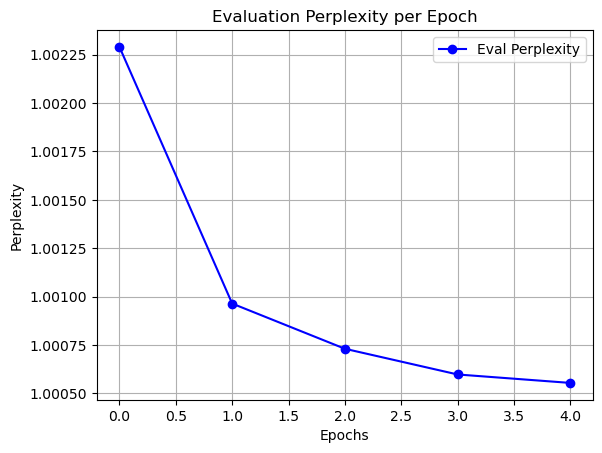

In [7]:
import math

perplexities = [math.exp(loss) for loss in eval_losses]

# Plotting
plt.plot(perplexities, marker='o', color='b', label='Eval Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Evaluation Perplexity per Epoch')
plt.legend()
plt.grid(True)
plt.show()